In [9]:
import torch
import numpy as np
from omegaconf import OmegaConf
from gpytorch.mlls import ExactMarginalLogLikelihood
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
import gpytorch

In [10]:
cfg = OmegaConf.load("/app/configs/train/train_hydra/train_scf_bo.yaml")
considered_points = np.array(cfg.considered_points)
train_X = torch.tensor(considered_points[:, [0, 1]], dtype=torch.double)
Y = torch.tensor(considered_points[:, [2]], dtype=torch.double)

In [13]:
gp = SingleTaskGP(
    train_X=train_X,
    train_Y=Y,
    input_transform=Normalize(d=2),
    outcome_transform=Standardize(m=1),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

In [14]:
probabilities = torch.linspace(*cfg.bounds.torch_probability, 50)
sigmas = torch.linspace(*cfg.bounds.sigma, 50)
product = torch.cartesian_prod(probabilities, sigmas)
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp.posterior(product)

In [16]:
lower, upper = observed_pred.confidence_region()

fig = go.Figure()
trace1 = go.Mesh3d(
    x=(product[:, 0]),
    y=(product[:, 1]),
    z=(observed_pred.mean.numpy()[:, 0]),
    opacity=0.5,
    color="rgba(244,22,100,0.6)",
)
fig.add_trace(trace1)

trace_lower = go.Mesh3d(
    x=(product[:, 0]),
    y=(product[:, 1]),
    z=(lower.numpy()),
    opacity=0.5,
    color="blue",
)
fig.add_trace(trace_lower)

trace_upper = go.Mesh3d(
    x=(product[:, 0]),
    y=(product[:, 1]),
    z=(upper.numpy()),
    opacity=0.5,
    color="blue",
)
fig.add_trace(trace_upper)
trace2 = go.Scatter3d(x=train_X[:, 0], y=train_X[:, 1], z=Y[:, 0], mode="markers")

fig.add_trace(trace2)

fig.update_layout(
    scene=dict(xaxis_title="p", yaxis_title="sigma", zaxis_title="Accuracy"),
    # zaxis=dict(title="accuracy"),
)
fig.show()

In [134]:
max_id = np.argmax(observed_pred.mean[:, 0]).item()
max_id, product[max_id]

(1184, tensor([0.4694, 5.5510]))

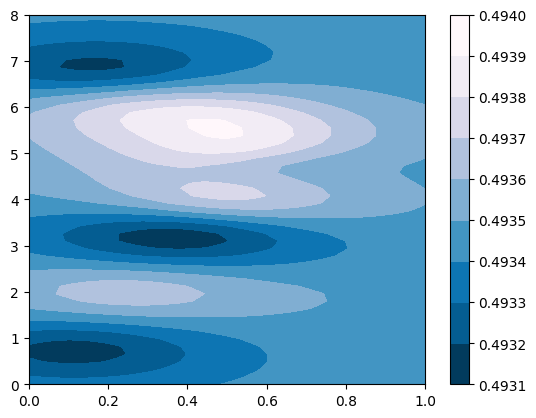

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma

x, y = np.meshgrid(probabilities.numpy(), sigmas.numpy())
z = np.reshape(observed_pred.mean[:, 0].numpy(), (50, 50)).T
z_min, z_max = z.min(), z.max()
from matplotlib import cm, ticker

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z, cmap=cm.PuBu_r, vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(cs)
plt.show()